In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import corner
import pandas as pd
from numba import njit

# --- FIXED COSMOLOGICAL PARAMETERS (for r_d calculation) ---
# These values are fixed for r_d, which depends on early-universe physics,
# not typically sampled in late-time DESI/SN analyses.
OMEGA_B_FIXED = 0.048 # A typical Planck/BBN value for Omega_b from previous 3D run's best-fit
OMEGA_K_FIXED = 0.0   # Flat universe assumed (can be changed if Omega_k is sampled)
Neff_fixed = 3.044 # Standard effective number of relativistic species
# --- Constants ---
c = 299792.458 # km/s (speed of light)

In [9]:
import numpy as np
import pandas as pd

# -----------------------------
# Load Pantheon+ Data
# -----------------------------
# Ensure these files are in your project directory:
# Pantheon+SH0ES.dat
# Pantheon+SH0ES_STAT+SYS.cov
df = pd.read_csv("Pantheon+SH0ES.dat", sep=r'\s+', comment='#') 
original_full_df_indices = df[df['USED_IN_SH0ES_HF'] == 1].index.values
df_filtered = df[df['USED_IN_SH0ES_HF'] == 1].reset_index(drop=True)

# These variables will be used globally by likelihood functions
z = df_filtered['zHD'].values
mu_obs = df_filtered['MU_SH0ES'].values

with open("Pantheon+SH0ES_STAT+SYS.cov") as f:
    N = int(f.readline())  
    flat_cov = np.loadtxt(f)
    cov_all = flat_cov.reshape((N, N))
cov = cov_all[np.ix_(original_full_df_indices, original_full_df_indices)]
jitter = 1e-9 * np.eye(cov.shape[0])
inv_cov = np.linalg.inv(cov + jitter)
print("✅ Pantheon+ Data Loaded.")

# -----------------------------
# Load DESI BAO Data
# -----------------------------
# Ensure these files are in your project directory:
# desi_2024_gaussian_bao_ALL_GCcomb_mean.txt
# desi_2024_gaussian_bao_ALL_GCcomb_cov.txt
desi_mean_file = "desi_2024_gaussian_bao_ALL_GCcomb_mean.txt"
desi_cov_file = "desi_2024_gaussian_bao_ALL_GCcomb_cov.txt"

desi_data_raw = pd.read_csv(desi_mean_file, sep=r'\s+', comment='#', header=None,
                            names=['z_eff', 'value', 'quantity_type'])

# These variables will be used globally by likelihood functions
z_eff_desi = desi_data_raw['z_eff'].values
observed_values_desi = desi_data_raw['value'].values
quantity_types_desi = desi_data_raw['quantity_type'].values

cov_desi_flat = np.loadtxt(desi_cov_file)
N_desi = len(observed_values_desi)
cov_desi = cov_desi_flat.reshape((N_desi, N_desi))
jitter_desi = 1e-9 * np.eye(cov_desi.shape[0])
inv_cov_desi = np.linalg.inv(cov_desi + jitter_desi)
print("✅ DESI BAO Data Loaded.")

✅ Pantheon+ Data Loaded.
✅ DESI BAO Data Loaded.


In [10]:
import numpy as np
from scipy.integrate import quad
from numba import njit 

# --- Define the Dark Energy Evolution Factor g(z) for CPL parametrization ---
@njit 
def g_z_CPL(z_val, w0, wa):
    a = 1.0 / (1.0 + z_val)
    if a <= 0:
        return 0.0 
    return a**(-3.0 * (1.0 + w0 + wa)) * np.exp(-3.0 * wa * (1.0 - a))

# --- Hubble Parameter H(z) for General Model (w0waCDM + Omega_k) ---
@njit 
def H_z_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    Omega_de0 = 1 - Omega_m - Omega_k
    
    if Omega_de0 < 0 or Omega_m < 0: 
        return np.inf 

    term_in_sqrt = Omega_m * (1.0 + z_val)**3 + Omega_k * (1.0 + z_val)**2 + Omega_de0 * g_z_CPL(z_val, w0, wa)
    
    if term_in_sqrt <= 0:
        return np.inf
        
    return H0 * np.sqrt(term_in_sqrt)

# --- Integrand for D_M_general ---
@njit 
def E_inv_for_DM_general_integrand_numba(z_prime, H0, Omega_m, w0, wa, Omega_k):
    Hz_prime = H_z_general(z_prime, H0, Omega_m, w0, wa, Omega_k)
    if not np.isfinite(Hz_prime) or Hz_prime == 0:
        return np.nan 
    return H0 / Hz_prime

# --- D_M_general --- (NOT @njit)
def D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    if isinstance(z_val, np.ndarray):
        integral_results = np.array([quad(E_inv_for_DM_general_integrand_numba, 0, zi, args=(H0, Omega_m, w0, wa, Omega_k))[0] for zi in z_val])
    else: 
        integral_results = quad(E_inv_for_DM_general_integrand_numba, 0, z_val, args=(H0, Omega_m, w0, wa, Omega_k))[0]
    
    if not np.all(np.isfinite(integral_results)):
        return -np.inf 
        
    return (c / H0) * integral_results

@njit 
def D_H_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    Hz_val = H_z_general(z_val, H0, Omega_m, w0, wa, Omega_k)
    if not np.isfinite(Hz_val) or Hz_val == 0:
        return np.inf 
    return c / Hz_val

# --- D_V_general --- (NOT @njit)
def D_V_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    dm_val = D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k) 
    dh_val = D_H_general(z_val, H0, Omega_m, w0, wa, Omega_k)
    
    if not np.all(np.isfinite(dm_val)) or not np.all(np.isfinite(dh_val)):
        return np.inf

    inner_val = z_val * dm_val**2 * dh_val
    if inner_val < 0:
        return np.inf 
        
    return inner_val**(1/3.0)

# --- Theoretical Sound Horizon (r_d) ---
@njit 
def r_d_th(H0, Omega_m, Omega_b):
    h = H0 / 100.0
    ombh2_calc = Omega_b * h**2 
    omch2_calc = Omega_m * h**2 - ombh2_calc 

    if not (ombh2_calc > 0.005 and omch2_calc > 0): 
        return np.inf 
        
    omegamh2_calc = Omega_m * h**2 
    if not (omegamh2_calc > 0):
        return np.inf

    rd = 147.05 * (ombh2_calc / 0.02236)**(-0.13) * \
         (omegamh2_calc / 0.1432)**(-0.23) * \
         (Neff_fixed / 3.04)**(-0.1) 
    return rd

In [11]:
import numpy as np

# --- General distance_modulus (for SNe) --- (NOT @njit)
def distance_modulus_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    dL = (1.0 + z_val) * D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k)
    if not np.all(np.isfinite(dL)): 
        return np.inf
    return 5 * np.log10(dL + 1e-10) + 25

# --- Log-likelihood for Pantheon+ in w0waCDM --- (NOT @njit)
def log_likelihood_pantheon_w0wa(theta, z_data, mu_obs_data, inv_cov_data):
    H0, Omega_m, w0, wa = theta 
    
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
    
    if not (-3 < w0 < 1 and -3 < wa < 2):
        return -np.inf
    
    if w0 + wa >= 0:
        return -np.inf

    # Omega_k is fixed to OMEGA_K_FIXED for Pantheon+ likelihood
    mu_th = distance_modulus_general(z_data, H0, Omega_m, w0, wa, OMEGA_K_FIXED)
    
    if not np.all(np.isfinite(mu_th)):
        return -np.inf
    
    delta = mu_obs_data - mu_th
    chi2 = delta @ inv_cov_data @ delta 
    
    return -0.5 * chi2

# --- Log-likelihood function for DESI BAO (General Model) --- (NOT @njit)
def log_likelihood_desi_general(theta, z_eff_desi_data, observed_values_desi_data, quantity_types_desi_data, inv_cov_desi_data,
                                sampled_params_names): # sampled_params_names passed to know which params are fixed

    # Extract parameters based on the specific model's 'theta' structure
    params_dict = {}
    for i, p_name in enumerate(sampled_params_names):
        params_dict[p_name] = theta[i]

    # Assign default values for parameters not sampled in this model
    H0 = params_dict.get('H0')
    Omega_m = params_dict.get('Omega_m')
    Omega_k = params_dict.get('Omega_k', OMEGA_K_FIXED) # Use fixed if not sampled
    w0 = params_dict.get('w0', -1.0) # Default to -1 (LambdaCDM) if not sampled
    wa = params_dict.get('wa', 0.0)  # Default to 0 (LambdaCDM) if not sampled
    # Omega_b is fixed as OMEGA_B_FIXED

    # --- Apply Priors (specific to each parameter) ---
    # These checks are crucial for the sampler.
    # Broad ranges to cover all models
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
    if 'Omega_k' in sampled_params_names and not (-0.3 < Omega_k < 0.3): # Prior for Omega_k
        return -np.inf
    if 'w0' in sampled_params_names and not (-3 < w0 < 1): # Prior for w0
        return -np.inf
    if 'wa' in sampled_params_names and not (-3 < wa < 2): # Prior for wa
        return -np.inf
    
    # Enforce w0 + wa < 0 for dynamical dark energy models, if w0 or wa are sampled
    if ('w0' in sampled_params_names or 'wa' in sampled_params_names) and w0 + wa >= 0:
        return -np.inf

    # --- Calculate r_d ---
    rd_model = r_d_th(H0, Omega_m, OMEGA_B_FIXED) # r_d_th from Cell 3
    if not np.isfinite(rd_model): 
        return -np.inf

    # --- Calculate Predicted BAO Values ---
    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi_data): 
        z_val = z_eff_desi_data[i] 
        
        val = np.nan 
        if quantity_type == 'DV_over_rs':
            val = D_V_general(z_val, H0, Omega_m, w0, wa, Omega_k) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_general(z_val, H0, Omega_m, w0, wa, Omega_k) / rd_model
        
        if not np.isfinite(val):
            return -np.inf
            
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    # --- Calculate Chi-squared ---
    delta_desi = observed_values_desi_data - predicted_values_desi
    chi2_desi = delta_desi @ inv_cov_desi_data @ delta_desi
    
    return -0.5 * chi2_desi

🔁 Running MCMC for DESI BAO (Flat LambdaCDM)...


100%|██████████| 15000/15000 [01:34<00:00, 158.88it/s]


✅ MCMC for DESI BAO (Flat LambdaCDM) completed!
Shape of processed DESI BAO (Flat LambdaCDM) samples: (38400, 2)


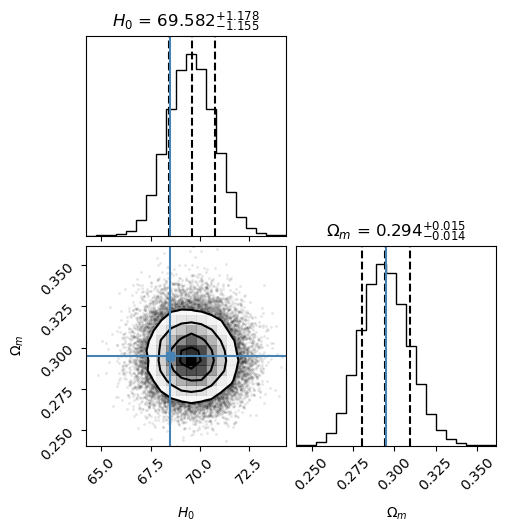

📊 $H_0$ = 69.5824 +1.1776 -1.1553
📊 $\Omega_m$ = 0.2944 +0.0151 -0.0140

Average acceptance fraction: 0.72


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for DESI BAO (Flat LambdaCDM) ---
# Parameters: H0, Omega_m
ndim_flat_lcdm = 2          
nwalkers_flat_lcdm = 32     
nsteps_flat_lcdm = 15000    
burn_in_flat_lcdm = 3000    
thin_factor_flat_lcdm = 10

# Initial guess (closer to DESI's preference for LambdaCDM)
initial_guess_flat_lcdm = np.array([68.5, 0.295]) 
pos_flat_lcdm = initial_guess_flat_lcdm + 1e-3 * np.random.randn(nwalkers_flat_lcdm, ndim_flat_lcdm)

# Data arguments for DESI BAO likelihood
data_args_desi = (z_eff_desi, observed_values_desi, quantity_types_desi, inv_cov_desi)

# List of parameter names for the likelihood to know what's sampled
# w0=-1, wa=0, Omega_k=0 are defaults in log_likelihood_desi_general
sampled_params_names_flat_lcdm = ['H0', 'Omega_m']

# Create a lambda function to pass correct args to log_likelihood_desi_general
# The last argument (sampled_params_names_flat_lcdm) is specific to this model
log_prob_fn_flat_lcdm = lambda theta, data_args: log_likelihood_desi_general(theta, *data_args, sampled_params_names_flat_lcdm)


sampler_flat_lcdm = emcee.EnsembleSampler(nwalkers_flat_lcdm, ndim_flat_lcdm, 
                                          log_prob_fn_flat_lcdm, 
                                          args=(data_args_desi,))

print("🔁 Running MCMC for DESI BAO (Flat LambdaCDM)...")
sampler_flat_lcdm.run_mcmc(pos_flat_lcdm, nsteps_flat_lcdm, progress=True)
print("✅ MCMC for DESI BAO (Flat LambdaCDM) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_flat_lcdm = sampler_flat_lcdm.get_chain(discard=burn_in_flat_lcdm, thin=thin_factor_flat_lcdm, flat=True)

# Store results for summary table
results_table = []
current_model_results = {'Model': 'Flat LambdaCDM'}
plot_labels = [r"$H_0$", r"$\Omega_m$"]

print(f"Shape of processed DESI BAO (Flat LambdaCDM) samples: {samples_flat_lcdm.shape}")
fig_flat_lcdm = corner.corner(samples_flat_lcdm, labels=plot_labels,
                               truths=initial_guess_flat_lcdm, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_flat_lcdm_corner.png", dpi=300, format='png')
plt.show()

# Print best-fit values and store
for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_flat_lcdm[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table.append(current_model_results)

print(f"\nAverage acceptance fraction: {np.mean(sampler_flat_lcdm.acceptance_fraction):.2f}")

🔁 Running MCMC for DESI BAO (LambdaCDM+Omega_k)...


100%|██████████| 20000/20000 [03:42<00:00, 89.89it/s]


✅ MCMC for DESI BAO (LambdaCDM+Omega_k) completed!
Shape of processed DESI BAO (LambdaCDM+Omega_k) samples: (102400, 3)


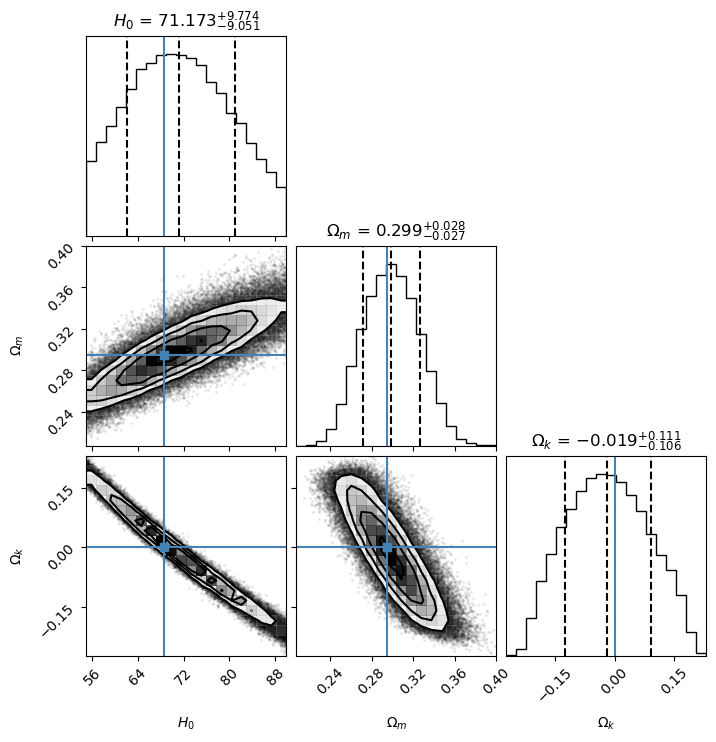

📊 $H_0$ = 71.1731 +9.7741 -9.0510
📊 $\Omega_m$ = 0.2991 +0.0276 -0.0274
📊 $\Omega_k$ = -0.0188 +0.1108 -0.1059

Average acceptance fraction: 0.62


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for DESI BAO (LambdaCDM+Omega_k) ---
# Parameters: H0, Omega_m, Omega_k
ndim_lcdm_omk = 3          
nwalkers_lcdm_omk = 64     
nsteps_lcdm_omk = 20000    
burn_in_lcdm_omk = 4000    
thin_factor_lcdm_omk = 10

# Initial guess (start at flat, Omega_k=0)
initial_guess_lcdm_omk = np.array([68.5, 0.295, 0.0]) 
pos_lcdm_omk = initial_guess_lcdm_omk + 1e-3 * np.random.randn(nwalkers_lcdm_omk, ndim_lcdm_omk)

# Data arguments for DESI BAO likelihood (already defined)
# sampled_params_names: H0, Omega_m, Omega_k
sampled_params_names_lcdm_omk = ['H0', 'Omega_m', 'Omega_k']
log_prob_fn_lcdm_omk = lambda theta, data_args: log_likelihood_desi_general(theta, *data_args, sampled_params_names_lcdm_omk)

sampler_lcdm_omk = emcee.EnsembleSampler(nwalkers_lcdm_omk, ndim_lcdm_omk, 
                                          log_prob_fn_lcdm_omk, 
                                          args=(data_args_desi,))

print("🔁 Running MCMC for DESI BAO (LambdaCDM+Omega_k)...")
sampler_lcdm_omk.run_mcmc(pos_lcdm_omk, nsteps_lcdm_omk, progress=True)
print("✅ MCMC for DESI BAO (LambdaCDM+Omega_k) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_lcdm_omk = sampler_lcdm_omk.get_chain(discard=burn_in_lcdm_omk, thin=thin_factor_lcdm_omk, flat=True)

current_model_results = {'Model': 'LambdaCDM+Omega_k'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_k$"]

print(f"Shape of processed DESI BAO (LambdaCDM+Omega_k) samples: {samples_lcdm_omk.shape}")
fig_lcdm_omk = corner.corner(samples_lcdm_omk, labels=plot_labels,
                               truths=initial_guess_lcdm_omk, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_lcdm_omk_corner.png", dpi=300, format='png')
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_lcdm_omk[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table.append(current_model_results)

print(f"\nAverage acceptance fraction: {np.mean(sampler_lcdm_omk.acceptance_fraction):.2f}")

🔁 Running MCMC for DESI BAO (wCDM)...


100%|██████████| 20000/20000 [04:10<00:00, 79.94it/s]


✅ MCMC for DESI BAO (wCDM) completed!
Shape of processed DESI BAO (wCDM) samples: (102400, 3)


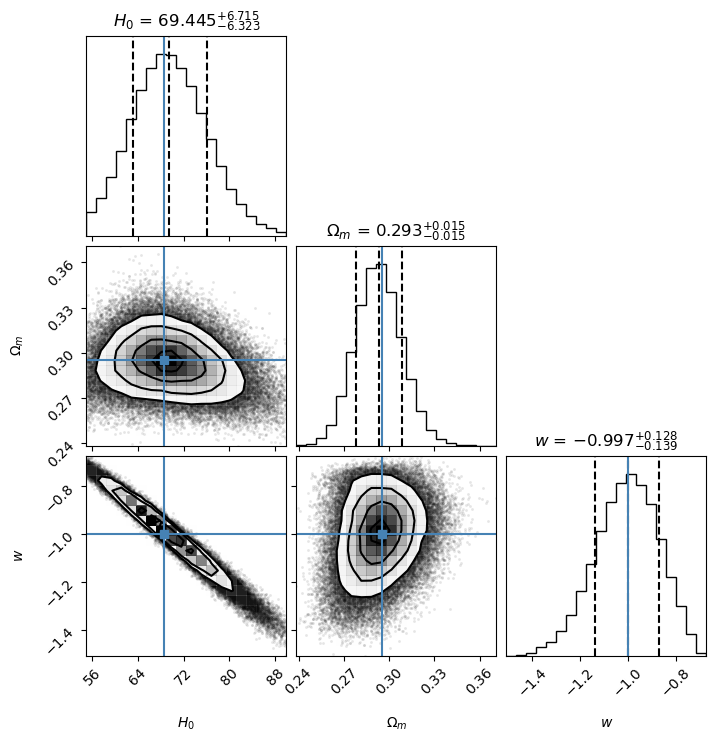

📊 $H_0$ = 69.4449 +6.7155 -6.3233
📊 $\Omega_m$ = 0.2929 +0.0155 -0.0148
📊 $w$ = -0.9973 +0.1277 -0.1393

Average acceptance fraction: 0.64


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for DESI BAO (wCDM) ---
# Parameters: H0, Omega_m, w
ndim_wcdm = 3          
nwalkers_wcdm = 64     
nsteps_wcdm = 20000    
burn_in_wcdm = 4000    
thin_factor_wcdm = 10

# Initial guess (start from LambdaCDM, w=-1)
initial_guess_wcdm = np.array([68.5, 0.295, -1.0]) 
pos_wcdm = initial_guess_wcdm + 1e-3 * np.random.randn(nwalkers_wcdm, ndim_wcdm)

# Data arguments for DESI BAO likelihood (already defined)
# sampled_params_names: H0, Omega_m, w0 (w), wa=0, Omega_k=0
sampled_params_names_wcdm = ['H0', 'Omega_m', 'w0'] # w is passed as w0 to general H(z)
log_prob_fn_wcdm = lambda theta, data_args: log_likelihood_desi_general(theta, *data_args, sampled_params_names_wcdm)

sampler_wcdm = emcee.EnsembleSampler(nwalkers_wcdm, ndim_wcdm, 
                                      log_prob_fn_wcdm, 
                                      args=(data_args_desi,))

print("🔁 Running MCMC for DESI BAO (wCDM)...")
sampler_wcdm.run_mcmc(pos_wcdm, nsteps_wcdm, progress=True)
print("✅ MCMC for DESI BAO (wCDM) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_wcdm = sampler_wcdm.get_chain(discard=burn_in_wcdm, thin=thin_factor_wcdm, flat=True)

current_model_results = {'Model': 'wCDM'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$w$"]

print(f"Shape of processed DESI BAO (wCDM) samples: {samples_wcdm.shape}")
fig_wcdm = corner.corner(samples_wcdm, labels=plot_labels,
                           truths=initial_guess_wcdm, 
                           show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_wcdm_corner.png", dpi=300, format='png')
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_wcdm[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table.append(current_model_results)

print(f"\nAverage acceptance fraction: {np.mean(sampler_wcdm.acceptance_fraction):.2f}")

🔁 Running MCMC for DESI BAO (w0waCDM)...


100%|██████████| 25000/25000 [04:39<00:00, 89.60it/s]


✅ MCMC for DESI BAO (w0waCDM) completed!
Shape of processed DESI BAO (w0waCDM) samples: (128000, 4)


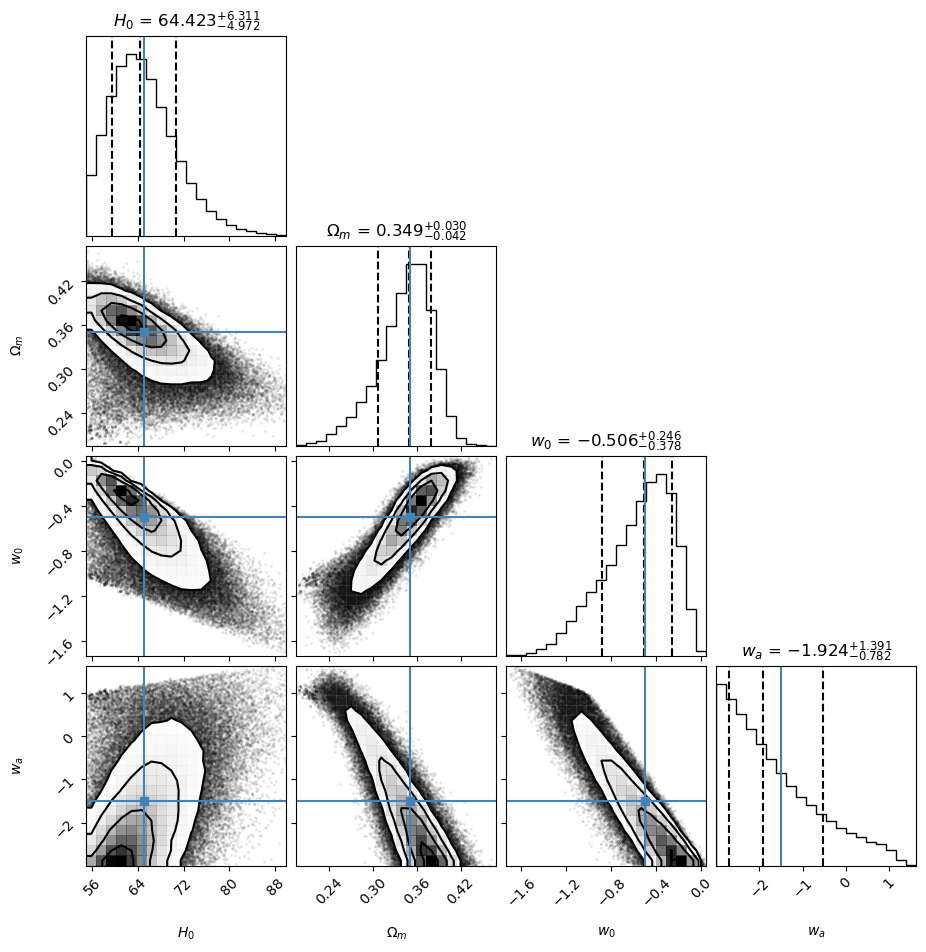

📊 $H_0$ = 64.4232 +6.3110 -4.9723
📊 $\Omega_m$ = 0.3491 +0.0301 -0.0422
📊 $w_0$ = -0.5064 +0.2462 -0.3785
📊 $w_a$ = -1.9242 +1.3906 -0.7821

Average acceptance fraction: 0.53


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for DESI BAO (w0waCDM) ---
# Parameters: H0, Omega_m, w0, wa
ndim_w0wa = 4 
nwalkers_w0wa = 64 
nsteps_w0wa = 25000 
burn_in_w0wa = 5000 
thin_factor_w0wa = 10

# Initial guess (based on DESI paper's discussion for w0waCDM, and LambdaCDM fits)
initial_guess_w0wa = np.array([65.0, 0.35, -0.5, -1.5]) 
pos_w0wa = initial_guess_w0wa + 1e-4 * np.random.randn(nwalkers_w0wa, ndim_w0wa) 

# Data arguments for DESI BAO likelihood (already defined)
# sampled_params_names: H0, Omega_m, w0, wa
sampled_params_names_w0wa = ['H0', 'Omega_m', 'w0', 'wa']
log_prob_fn_w0wa = lambda theta, data_args: log_likelihood_desi_general(theta, *data_args, sampled_params_names_w0wa)


sampler_w0wa = emcee.EnsembleSampler(nwalkers_w0wa, ndim_w0wa, 
                                          log_prob_fn_w0wa, 
                                          args=(data_args_desi,))

print("🔁 Running MCMC for DESI BAO (w0waCDM)...")
sampler_w0wa.run_mcmc(pos_w0wa, nsteps_w0wa, progress=True)
print("✅ MCMC for DESI BAO (w0waCDM) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_w0wa = sampler_w0wa.get_chain(discard=burn_in_w0wa, thin=thin_factor_w0wa, flat=True)

current_model_results = {'Model': 'w0waCDM'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"]

print(f"Shape of processed DESI BAO (w0waCDM) samples: {samples_w0wa.shape}")
fig_w0wa = corner.corner(samples_w0wa, labels=plot_labels,
                           truths=initial_guess_w0wa, 
                           show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_w0wa_corner.png", dpi=300, format='png')
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_w0wa[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table.append(current_model_results)

print(f"\nAverage acceptance fraction: {np.mean(sampler_w0wa.acceptance_fraction):.2f}")

🔁 Running MCMC for DESI BAO (w0waCDM+Omega_k)...


100%|██████████| 30000/30000 [09:56<00:00, 50.31it/s]


✅ MCMC for DESI BAO (w0waCDM+Omega_k) completed!
Shape of processed DESI BAO (w0waCDM+Omega_k) samples: (307200, 5)


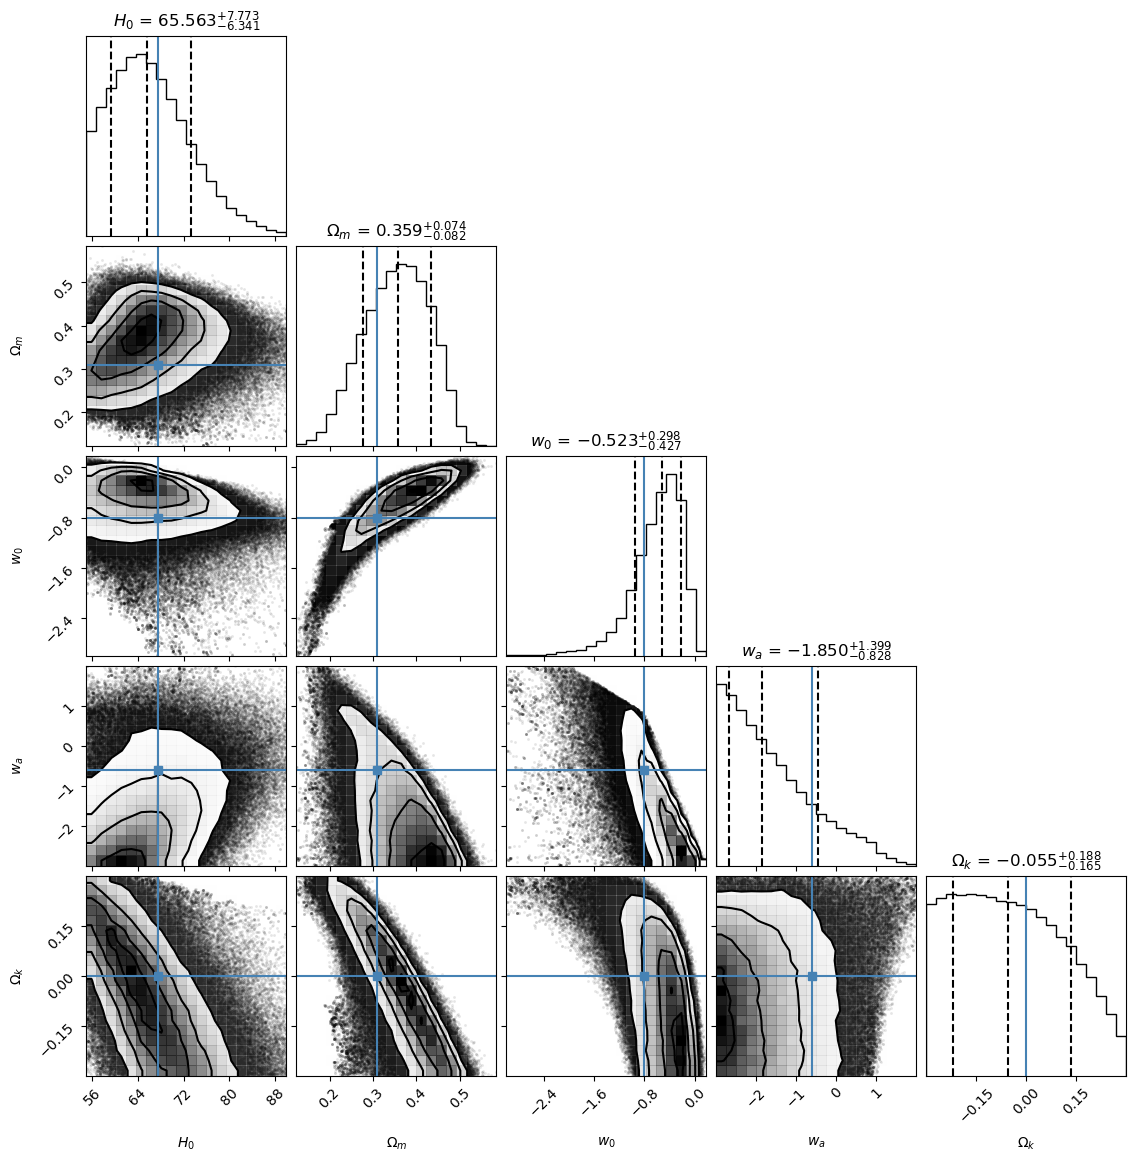

📊 $H_0$ = 65.5635 +7.7726 -6.3410
📊 $\Omega_m$ = 0.3585 +0.0737 -0.0822
📊 $w_0$ = -0.5226 +0.2976 -0.4274
📊 $w_a$ = -1.8502 +1.3988 -0.8279
📊 $\Omega_k$ = -0.0553 +0.1881 -0.1653

Average acceptance fraction: 0.37


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for DESI BAO (w0waCDM+Omega_k) ---
# Parameters: H0, Omega_m, w0, wa, Omega_k
ndim_w0wa_omk = 5          
nwalkers_w0wa_omk = 128    # Increased for 5D (>= 2*ndim)
nsteps_w0wa_omk = 30000    # More steps
burn_in_w0wa_omk = 6000    # More burn-in
thin_factor_w0wa_omk = 10

# Initial guess (start at flat LambdaCDM values for H0, Om, w0=-1, wa=0, Ok=0)
initial_guess_w0wa_omk = np.array([67.5, 0.31, -0.8, -0.6, 0.0]) # Start near combined w0wa but with Ok=0
pos_w0wa_omk = initial_guess_w0wa_omk + 1e-4 * np.random.randn(nwalkers_w0wa_omk, ndim_w0wa_omk) 

# Data arguments for DESI BAO likelihood (already defined)
# sampled_params_names: H0, Omega_m, w0, wa, Omega_k
sampled_params_names_w0wa_omk = ['H0', 'Omega_m', 'w0', 'wa', 'Omega_k']
log_prob_fn_w0wa_omk = lambda theta, data_args: log_likelihood_desi_general(theta, *data_args, sampled_params_names_w0wa_omk)

sampler_w0wa_omk = emcee.EnsembleSampler(nwalkers_w0wa_omk, ndim_w0wa_omk, 
                                          log_prob_fn_w0wa_omk, 
                                          args=(data_args_desi,))

print("🔁 Running MCMC for DESI BAO (w0waCDM+Omega_k)...")
sampler_w0wa_omk.run_mcmc(pos_w0wa_omk, nsteps_w0wa_omk, progress=True)
print("✅ MCMC for DESI BAO (w0waCDM+Omega_k) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_w0wa_omk = sampler_w0wa_omk.get_chain(discard=burn_in_w0wa_omk, thin=thin_factor_w0wa_omk, flat=True)

current_model_results = {'Model': 'w0waCDM+Omega_k'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$", r"$\Omega_k$"]

print(f"Shape of processed DESI BAO (w0waCDM+Omega_k) samples: {samples_w0wa_omk.shape}")
fig_w0wa_omk = corner.corner(samples_w0wa_omk, labels=plot_labels,
                               truths=initial_guess_w0wa_omk, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig("desi_w0wa_omk_corner.png", dpi=300, format='png')
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_w0wa_omk[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table.append(current_model_results)

print(f"\nAverage acceptance fraction: {np.mean(sampler_w0wa_omk.acceptance_fraction):.2f}")

In [17]:
import pandas as pd

print("\n--- Summary of DESI BAO Cosmological Parameter Constraints ---")

# Convert the list of dictionaries to a pandas DataFrame
# Fill missing values for parameters not sampled in all models
summary_df = pd.DataFrame(results_table).fillna('-')

# Reorder columns for better readability (optional)
# Get all unique parameter labels found in the results_table
all_param_labels = sorted(list(set(p for row in results_table for p in row if p != 'Model')))
# Define a desired order for plotting common parameters, and then others
desired_order = ['Model', r"$H_0$", r"$\Omega_m$", r"$\Omega_k$", r"$w$", r"$w_0$", r"$w_a$"]
# Filter desired_order to only include labels present in this specific results_table, then add others
final_columns = [col for col in desired_order if col in summary_df.columns]
remaining_cols = [col for col in summary_df.columns if col not in final_columns]
summary_df = summary_df[final_columns + sorted(remaining_cols)]


# Print the table
# Use to_string() to display all rows/columns without truncation
print(summary_df.to_string())

print("\n(Values are Median +Upper_Error -Lower_Error, for 68% Credible Intervals)")


--- Summary of DESI BAO Cosmological Parameter Constraints ---
               Model                      $H_0$                $\Omega_m$                 $\Omega_k$                        $w$                      $w_0$                      $w_a$
0     Flat LambdaCDM  69.5824 (+1.1776 -1.1553)  0.2944 (+0.0151 -0.0140)                          -                          -                          -                          -
1  LambdaCDM+Omega_k  71.1731 (+9.7741 -9.0510)  0.2991 (+0.0276 -0.0274)  -0.0188 (+0.1108 -0.1059)                          -                          -                          -
2               wCDM  69.4449 (+6.7155 -6.3233)  0.2929 (+0.0155 -0.0148)                          -  -0.9973 (+0.1277 -0.1393)                          -                          -
3            w0waCDM  64.4232 (+6.3110 -4.9723)  0.3491 (+0.0301 -0.0422)                          -                          -  -0.5064 (+0.2462 -0.3785)  -1.9242 (+1.3906 -0.7821)
4    w0waCDM+Omega_k  65.5